# QML for VBS 

## Imports

In [1]:
from qiskit import *
from qiskit import IBMQ, Aer

from qiskit.circuit import ParameterVector
from qiskit.visualization.bloch import Bloch
from qiskit.aqua.components.optimizers import SPSA
from qiskit.tools.monitor import job_monitor

import matplotlib.pyplot as plt
%matplotlib inline  
import numpy as np
import math
import time
import pickle
import random 
from random import randrange

In [2]:
qiskit.__qiskit_version__

{'qiskit-terra': '0.16.1',
 'qiskit-aer': '0.7.2',
 'qiskit-ignis': '0.5.1',
 'qiskit-ibmq-provider': '0.11.1',
 'qiskit-aqua': '0.8.1',
 'qiskit': '0.23.2'}

## Script parameters
* quantum_hw: set to '0' to use simulator or to '1' to use a real quantum computer;
* bknd: quantum computer used;
* Shots: number of attempts for each measuration to get a statistical result;
* max_circuits_supported: maximum number of circuits supported on Quantum Experience (use an number multiple of number_classes);
* layout: configuration of the qubits chosen from the quantum computer. It links each qubit of the algorithm to the corresponding qubits of the real hardware;
* number_training: number of events of each type used during the training phase;
* number_testing: number of events of each type used during the testing phase;
* SPSA_steps: number of steps for SPSA algorithm;
* number_var: total number of variables used to classify each event;
* number_classes: number of classes for which classification is performed;
* ii,jj,kk,ll,mm : numbers associated to the variables used for the classification of each event (their order is relevant):
* c_e_ii,c_e_jj,c_e_kk,c_e_ll,c_e_mm: crossentropy functions associated to the variables distributions;
* L1: Number of repetitions of the Mapping Circuit;
* L2: Number of repetitions of the Variational part of the Quantum Circuit;
* print_loss_func: 1-> prints the loss function evaluations, 0-> doesn't;
* plot_AUC_image: 1-> prints the AUC graph, 0-> doesn't;
* plot_data: 1-> prints the data images, 0-> doesn't;
* sound: 1-> acustic signal at the end of the execution, 0 -> no signal;
* save_results: 1 -> save result on an externjal file, 0 -> doesn't;


In [3]:
quantum_hw = 0
bknd = 'ibmq_athens'
Shots = 8192                        
max_circuits_supported = 7400        
layout = [0,1,2,3,4]

number_training = 200              
number_testing = 2000
SPSA_steps = 100                     
number_var = 5                      
number_classes = 2                  
ratio = 1

ii = 35
jj = 40
kk = 43
ll = 54 
mm = 45


c_e_ii = 23.807574615434635
c_e_jj = 8.177020948034661
c_e_kk = 7.568297786037082
c_e_ll = 7.194341957347005
c_e_mm = 4.532632440369189 


L1 = 1                 
L2 = 2                 


print_loss_func = 1     
plot_AUC_image = 1      
plot_data = 1 
sound = 0
save_results = 0

## Auxiliary functions

#### Definitions of useful functions
The following are useful to reshape the variables distributions before the mapping phase

In [4]:
def Cheb(x):
    return np.cos((x+1)*np.pi/2)

def InvCheb(x):
    return 2*np.arccos((x+1)/2)/np.pi-1

def Sqrt(x):
    x = np.clip(x,-1,1)
    return np.sqrt((x+1)/2)*2 -1

def InvSqrt(x):
    return ((x+1)**2 -1)/2

#### Labelling function
It labels the input events into the classes (implemented only for 2 classes)

In [5]:
def f_label(i):
    if i%2==0:
        result = [1,0]
    else:
        result = [0,1]
    return result

#### Normalization function (softmax function)

In [6]:
def softmax_function(x):
    F = [math.exp(x[0]),math.exp(x[1]),math.exp(x[2]),math.exp(x[3])]
    for i in range(0,2):
        F[i] = F[i]/sum([math.exp(x[0]),math.exp(x[1])])
    for i in range(2,4):
        F[i] = F[i]/sum([math.exp(x[2]),math.exp(x[3])])
    return F

#### Measuration  function
The following determines how measuration values obtained from the quantum circuit are treated in order to obtain a single result for each event

In [7]:
def f_measuration(count):
    Z_m = np.zeros(4)
    for i in range(0,2**(number_bits)):
        for k in range(0,4):
            if eig[i][1-k] == '0' and eig[i] in count:
                Z_m[k] += count[eig[i]]  

    Z_m = (2*np.array(Z_m)-Shots)/Shots
    y = softmax_function(Z_m)
    return y

#### Mapping function

In [8]:
def Phi_function(x,y,z,a,b):
    return [np.arcsin(y),np.arccos(y**2),np.arcsin(x),np.arccos(x**2),np.arcsin(z),np.arccos(z**2),np.arcsin(a),np.arccos(a**2),np.arcsin(b),np.arccos(b**2)] 
    #the length of the array has to be equal to the number of qubits

## Parameters introduction

In [9]:
def training_set(par,circuit,theta,Phi_f):
    #the following lines are destineted to the creation of the input for bind.parameters()
    pre_input = [[theta.params[k], par[k]] for k in range(0, number_parameters)]
    input_p2 = []
    for i in range(0,len(pre_input)):
        input_p2 = input_p2  + [pre_input[i][0]] + [pre_input[i][1]]
    the_input = [{Phi:Phi_f[i]} for i in range(0,len(X))]
    for i in range(0,len(X)):
        for j in range(0,len(pre_input)):
            the_input[i][pre_input[j][0]] = pre_input[j][1]

    #evaluation of the circuit with the parameters setted by the input, for all possible values in X
    Counts = []
    for j in range(0,N):
        circuits_dataset = [circuit.bind_parameters(the_input[i+j*max_circuits_supported]) for i in range(0,max_circuits_supported)]
        if quantum_hw == 1:
            provider = IBMQ.get_provider('ibm-q')
            qcomp = provider.get_backend(bknd)
        else:
            qcomp = Aer.get_backend('qasm_simulator')
        job = execute(circuits_dataset, backend = qcomp, optimization_level = 0, shots=Shots, initial_layout = layout)
        job_monitor(job)
        result = job.result()
        counts = result.get_counts()
        Counts = Counts + counts

    circuits_dataset = [circuit.bind_parameters(the_input[i+max_circuits_supported*N]) for i in range(0,remainder)]
    if quantum_hw == 1:
        provider = IBMQ.get_provider('ibm-q')
        qcomp = provider.get_backend(bknd)
    else:
        qcomp = Aer.get_backend('qasm_simulator')
    job = execute(circuits_dataset, backend = qcomp, optimization_level = 0, shots=Shots, initial_layout = layout)
    job_monitor(job)
    result = job.result()
    counts = result.get_counts()

    Counts = Counts + counts
    counts = Counts
    
#    ### Just to check that the circuits look right...
#    print(circuits_dataset[0].decompose())
    
    return counts

## Loading data for training
data loading variable-per-variable properly deformed and rescaled in the interval [-1,1]

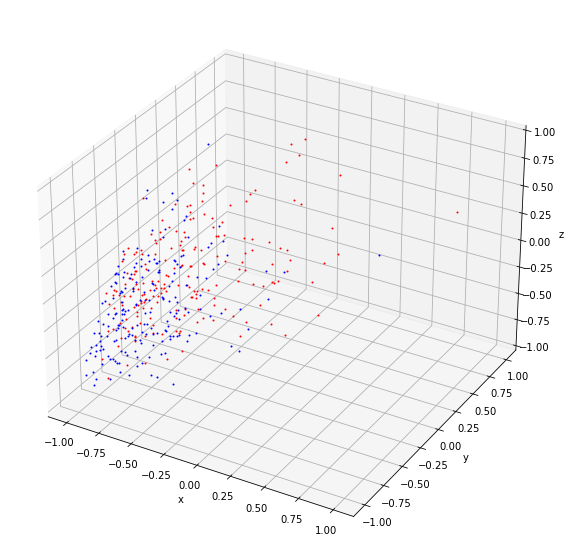

In [10]:
#DATA CAPTURE
#Here data are normalized in [-1,1] and, eventually, "stretched" or "squized" by using the previous functions.
#Odd and even elements of the following vectors will apparain to different classes (by choice)

data2 = pickle.load(open("background_balanced.pkl","rb"))  
data1 = pickle.load(open("signal_balanced.pkl","rb"))
Ind = data1.columns
start = 0

X1 = np.array(data1[Ind[ii]])
X2 = np.array(data2[Ind[ii]])

XX = []
for i in range(start, start + number_training):
    XX.append(X1[i])
    XX.append(X2[i])

Xmax = max(max(XX),max(XX))
Xmin = min(min(XX),min(XX))

X = []
for i in range(0,number_training):
    X.append(X1[i])
    X.append(X2[i])

#X are normalizated over [-1,1]
if Xmax-Xmin!= 0:
    X = (np.array(X)- Xmin)*2/(Xmax-Xmin)
X = np.array(X) -1
#X = Sqrt(X)
X = np.clip(X,-1,1)

############################################################

Y1 = np.array(data1[Ind[jj]])
Y2 = np.array(data2[Ind[jj]])

YY = []
for i in range(start, start + number_training):
    YY.append(Y1[i])
    YY.append(Y2[i])

Ymax = max(max(YY),max(YY))
Ymin = min(min(YY),min(YY))


Y = []
for i in range(0,number_training):
    Y.append(Y1[i])
    Y.append(Y2[i])

#Y are normalizated over [-1,1]
if Ymax-Ymin!= 0:
    Y = (np.array(Y)- Ymin)*2/(Ymax-Ymin)
Y = np.array(Y)  -1
Y = Sqrt(Y)
Y = np.clip(Y,-1,1)

############################################################

Z1 = np.array(data1[Ind[kk]])
Z2 = np.array(data2[Ind[kk]])

ZZ = []
for i in range(start, start + number_training):
    ZZ.append(Z1[i])
    ZZ.append(Z2[i])

Zmax = max(max(ZZ),max(ZZ))
Zmin = min(min(ZZ),min(ZZ))


Z = []
for i in range(0,number_training):
    Z.append(Z1[i])
    Z.append(Z2[i])

#Z are normalizated over [-1,1]
if Zmax-Zmin!= 0:
    Z = (np.array(Z)- Zmin)*2/(Zmax-Zmin)
Z = np.array(Z)  -1
#Z = Cheb(Z)
Z = Sqrt(Z)
Z = np.clip(Z,-1,1)

############################################################
A1 = np.array(data1[Ind[ll]])
A2 = np.array(data2[Ind[ll]])

AA = []
for i in range(start, start + number_training):
    AA.append(A1[i])
    AA.append(A2[i])

Amax = max(max(AA),max(AA))
Amin = min(min(AA),min(AA))


A = []
for i in range(0,number_training):
    A.append(A1[i])
    A.append(A2[i])

#Z are normalizated over [-1,1]
if Amax-Amin!= 0:
    A = (np.array(A)- Amin)*2/(Amax-Amin)
A = np.array(A)  -1
#A = Sqrt(A)
A = np.clip(A,-1,1)

############################################################

B1 = np.array(data1[Ind[mm]])
B2 = np.array(data2[Ind[mm]])

BB = []
for i in range(start, start + number_training):
    BB.append(B1[i])
    BB.append(B2[i])

Bmax = max(max(BB),max(BB))
Bmin = min(min(BB),min(BB))

B = []
for i in range(0,number_training):
    B.append(B1[i])
    B.append(B2[i])

#X are normalizated over [-1,1]
if Bmax-Bmin!= 0:
    B = (np.array(B)- Bmin)*2/(Bmax-Bmin)
B = np.array(B) -1
#X = Sqrt(B)
B = np.clip(B,-1,1)

############################################################

X1 = []
X2 = []
Y1 = []
Y2 = []
Z1 = []
Z2 = []
A1 = []
A2 = []
B1 = []
B2 = []


for i in range(0,len(X)):
    if i % 2 == 0:
        X1.append(X[i])
        Y1.append(Y[i])
        Z1.append(Z[i])
        A1.append(A[i])
        B1.append(B[i])
    else:
        X2.append(X[i])
        Y2.append(Y[i])
        Z2.append(Z[i])
        A2.append(A[i])
        B2.append(B[i])

#TRAINING SET VISUALIZATION
if plot_data == 1:
    %matplotlib inline
    fig = plt.figure(figsize = (10,10)) 
    ax = plt.axes(projection='3d')
    ax.plot3D(X1,Y1,Z1,'ro',markersize = 1)
    ax.plot3D(X2,Y2,Z2,'bo',markersize = 1)
    ax.set_xlabel('x')   
    ax.set_ylabel('y')   
    ax.set_zlabel('z') 

## Preparing for the training
division of the initial vector in smaller vectors in order to fit "max_circuits_supported"

In [11]:
#this part of the program is needed in the case where there exists a maximal number of trainable circuits per-time
N = int(len(X)/max_circuits_supported)

v = np.zeros((N, max_circuits_supported))
for i in range(0,N):
    for j in range(0,max_circuits_supported):
        v[i][j] = X[j+i*max_circuits_supported]
        
remainder = len(X)%max_circuits_supported     
v_last = np.zeros(remainder)
for j in range(0,remainder):
    v_last[j] = X[j+N*max_circuits_supported]

training set mapping function

In [12]:
number_qubits = 1 #for EACH variable
number_bits = number_classes*2

#evaluation of phi
Phi_f = np.zeros((len(X), 2*number_var))
for i in range(0,len(X)):
    for j in range(0, 2*number_var):
        Phi_f[i][j] = Phi_function(X[i],Y[i],Z[i],A[i],B[i])[j]

training set mapping function

In [13]:
#defining the label function for the trainingset, remember that odd and even events correspond to different classes

f_l = []
for i in range(0,len(X)):
    f_l.append(f_label(i))

#### Build the variational circuit

In [14]:
number_parameters = 4*number_qubits*number_var

Phi = ParameterVector('Φ', 2*number_var) #int(number_qubits*(number_qubits+1)/2)
theta = ParameterVector('θ',number_parameters)

## Circuit construction

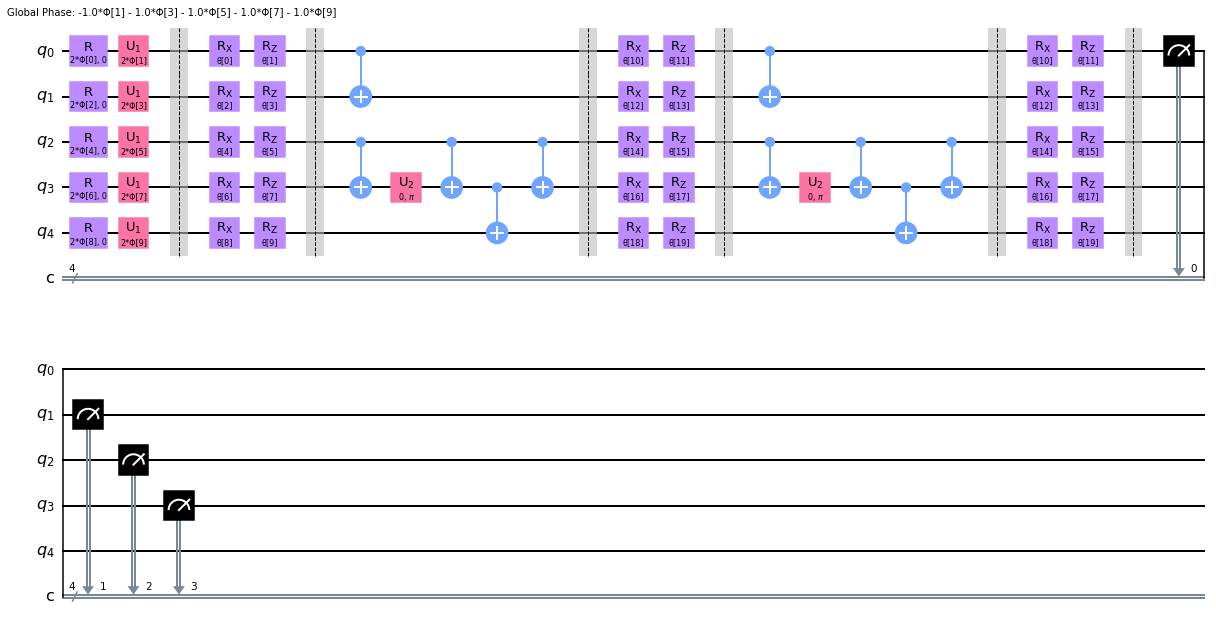

In [15]:
circuit = QuantumCircuit(number_var*number_qubits, number_bits)

for i in range(0,L1):

    for j in range(0,number_var):
        for k in range(0,number_qubits):
            circuit.rx(2*Phi[j*2],j+(number_var)*k)  
            circuit.rz(2*Phi[j*2+1],j+(number_var)*k) 
circuit.barrier()

#rotations
s = 0
for i in range(0,number_qubits*number_var):
    variational_circuit = QuantumCircuit(1)
    variational_circuit.rx(theta[s],0)
    s += 1
    variational_circuit.rz(theta[s],0)
    s += 1
    var_inst = variational_circuit.to_instruction()

    circuit.append(var_inst,[i])
circuit.barrier()
S = s

for k in range(0,L2):    
    #entanglement  

    circuit.cx(0,1)
    circuit.cx(2,3)
    circuit.h(3)
    circuit.cx(2,3)
    circuit.cx(3,4)
    circuit.cx(2,3)

    
    circuit.barrier()
    
    #rotations
    s = S
    for i in range(0,number_qubits*number_var):
        variational_circuit = QuantumCircuit(1)
        variational_circuit.rx(theta[s],0)
        s += 1
        variational_circuit.rz(theta[s],0)
        s += 1
        var_inst = variational_circuit.to_instruction()

        circuit.append(var_inst,[i])
    circuit.barrier()

    
# circuit.measure(range(0,2),range(0,2))
circuit.measure(range(0,4),range(0,4))


%matplotlib inline  
decomposed_circuit = circuit.decompose()
decomposed_circuit.draw('mpl')

## Cost function production and plot
The cost function is chosen to be the kullback-Leibler divergence

<IPython.core.display.Javascript object>


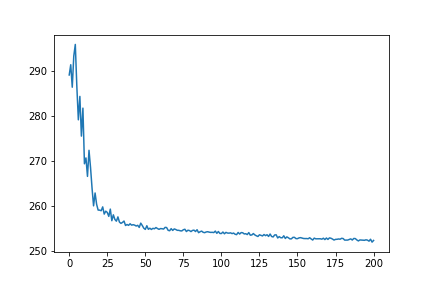

In [16]:
%matplotlib notebook

X_plot = []
Y_plot = []

fig = plt.figure()
ax = fig.add_subplot()
plt.ion()

fig.show()
fig.canvas.draw()
iter_count = 0

def plot_cost_fun(y):
    global iter_count
    global X_plot
    global Y_plot
    X_plot.append(iter_count)
    Y_plot.append(y)
    ax.clear()
    ax.plot(X_plot,Y_plot)
    fig.canvas.draw()
    iter_count += 1   
    


def cost_function(par,*args): #par will contain the parameters at each step of the optimization

    circuit = args[0]
    theta = args[1]
    Phi_f = args[2]
    
    counts = training_set(par,circuit,theta,Phi_f)

    L = 0
    print("\n current value of parameters: " , par )
        
    #estimated label 
    for i in range(0,len(X)):
        for k in range(0,2):
            yi = f_measuration(counts[i])
            Yi = ((c_e_ii+c_e_jj)*yi[k] + (c_e_kk+c_e_ll)*yi[2+k])/(c_e_ii+c_e_jj+c_e_kk+c_e_ll)           
            L += (-f_l[i][k]*math.log(Yi))*(((i+1)%2)*ratio + i%2)
            
    if print_loss_func == 1:
        plot_cost_fun(L)
    
    print("current value for loss function: " , L , "\n\n" )
    return L

## Training

In [17]:
factor = 100

#creation of the eigenstates list, i.e: ['000', '001',... ]
eig = []
for i in range(0,2**(number_bits)):
    eig.append('')

for j in range(0,number_bits):
    for i in range(0,2**j): 
        for k in range(0,(2**(number_bits-j))):            
            if (k % 2) == 0:
                eig[i+k*2**j] = '0' + eig[i+k*2**j] 
            else:
                eig[i+k*2**j] = '1' + eig[i+k*2**j]    

In [18]:
#initial values for parameters are chosen randomly
theta_0 = []


for i in range(0, number_parameters):
    theta_0.append(random.uniform(0, 2*np.pi))
theta_0 = np.array(theta_0)

#In the following c0 is the firt step "a", c1 is the initial "c", c2 is the "alpha" parameter, c3 the "gamma" parameter
#and finally c4 another parameter to control "a" (as like as "alpha" does)
t = time.time()

Optimizer = SPSA(max_trials = 1e3, save_steps = 1, last_avg = 1, c0 = 10/(number_training), c1 = 0.3, c2 = 1, c3 = 0.7, c4 = 0, 
                 skip_calibration = False)

# cost_final, theta_best, cost_plus_save, cost_minus_save, theta_plus_save, theta_minus_save =  (
#     Optimizer._optimization(cost_function,theta_0, SPSA_steps, save_steps = 1, last_avg = 3))

fw = Optimizer.wrap_function(cost_function,(circuit,theta,Phi_f))

cost_final, theta_best, cost_plus_save, cost_minus_save, theta_plus_save, theta_minus_save =  (
    Optimizer._optimization(fw,theta_0, SPSA_steps, save_steps = 1, last_avg = 3) )

print(cost_final,theta_best)

elapsed = time.time() - t
print(elapsed)


C:\Users\dado\anaconda3\lib\site-packages\qiskit\aqua\components\optimizers\spsa.py:93: DeprecationWarning: The max_trials parameter is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use maxiter instead.
  warnings.warn('The max_trials parameter is deprecated as of '


Job Status: job has successfully run

 current value of parameters:  [3.52352685 4.06177634 5.35458037 0.19650071 1.57024846 3.45726756
 1.08973322 0.99861795 5.32663314 3.45985861 5.49811653 4.83037439
 4.87796859 3.50234151 5.71185625 0.41592507 2.36964031 5.94868755
 2.14953282 1.07823657]
current value for loss function:  289.18785049193644 


Job Status: job has successfully run

 current value of parameters:  [ 2.92352685  3.46177634  5.95458037  0.79650071  0.97024846  2.85726756
  0.48973322  0.39861795  5.92663314  2.85985861  6.09811653  5.43037439
  5.47796859  4.10234151  5.11185625 -0.18407493  1.76964031  5.34868755
  2.74953282  1.67823657]
current value for loss function:  291.46355522541586 


Job Status: job has successfully run

 current value of parameters:  [3.59784057 4.13609007 5.28026664 0.12218698 1.64456218 3.16223796
 0.79470362 0.70358835 5.25231942 3.53417234 5.4238028  4.75606066
 4.80365487 3.79737111 5.78616997 0.49023879 2.07461071 5.65365795
 2.4445624

current value for loss function:  259.89577188447976 


Job Status: job has successfully run

 current value of parameters:  [ 4.38703298  4.11675373  5.4486177  -0.27615971  0.76564583  2.04319841
 -0.42794732 -0.81782233  3.28950518  3.06496351  4.00951492  4.64717423
  5.10227899  3.69528102  5.9033488  -0.24955299  3.06858699  4.60737979
  2.48870595 -0.4591719 ]
current value for loss function:  258.296979944053 


Job Status: job has successfully run

 current value of parameters:  [ 4.34775226  4.05640427  5.40933698 -0.31544043  0.70529637  1.98284895
 -0.46722804 -0.87817179  3.22915572  3.12531297  3.94916546  4.70752369
  5.04192953  3.75563048  5.96369826 -0.30990245  3.02930627  4.66772925
  2.54905541 -0.51952136]
current value for loss function:  258.94268678208397 


Job Status: job has successfully run

 current value of parameters:  [ 4.44738244  4.15603444  5.50896716 -0.21581026  0.80492655  2.08247913
 -0.36759786 -0.77854161  3.3287859   3.02568279  4.04879563  4.

Job Status: job has successfully run

 current value of parameters:  [ 4.50512702  4.0228176   5.56850994 -0.26103838  0.82640891  2.01766637
 -0.3469363  -1.05784377  3.08574596  3.07087334  3.83135122  4.70239419
  5.05669028  3.53660916  5.93142222 -0.16697154  3.16506634  4.40384242
  2.53899165 -0.55407075]
current value for loss function:  255.8068493306099 


Job Status: job has successfully run

 current value of parameters:  [ 4.49888567  4.02905895  5.49740464 -0.18993307  0.82016756  2.02390772
 -0.35317765 -0.98673847  3.15685126  3.06463198  3.76024592  4.69615284
  5.06293163  3.46550386  5.93766357 -0.23807684  3.23617164  4.47494772
  2.5327503  -0.5478294 ]
current value for loss function:  255.33962115290595 


Job Status: job has successfully run

 current value of parameters:  [ 4.43402172  4.0939229   5.56226859 -0.25479702  0.75530361  2.08877167
 -0.4180416  -1.05160242  3.09198731  2.99976804  3.82510987  4.63128889
  5.12779558  3.5303678   6.00252752 -0.173212

current value for loss function:  255.06387120533162 


Job Status: job has successfully run

 current value of parameters:  [ 4.45401123  4.00070114  5.374367   -0.20574946  0.77037654  1.94944465
 -0.30144146 -1.02496632  3.09604229  3.05505497  3.71237537  4.74483792
  5.00614826  3.3631847   6.02843693 -0.31842465  3.26940729  4.4755939
  2.53448821 -0.53680983]
current value for loss function:  254.672516485998 


Job Status: job has successfully run

 current value of parameters:  [ 4.40420271  4.05050966  5.42417552 -0.15594094  0.72056802  1.99925316
 -0.35124998 -0.9751578   3.14585081  3.10486348  3.76218388  4.6950294
  5.05595678  3.41299322  5.97862841 -0.26861614  3.31921581  4.42578539
  2.58429673 -0.58661835]
current value for loss function:  255.00086115179255 


Job Status: job has successfully run

 current value of parameters:  [ 4.41410634  4.04060602  5.41427189 -0.16584457  0.77930759  1.98934953
 -0.29251041 -1.03389737  3.13594717  3.09495985  3.75228025  4.70

Job Status: job has successfully run

 current value of parameters:  [ 4.47438453  3.97188883  5.3970645  -0.20019148  0.78635923  1.94716217
 -0.35862574 -0.97878671  3.10747325  3.07965307  3.68509485  4.75553855
  5.00799566  3.34452334  6.04008057 -0.23286419  3.3125248   4.47345567
  2.48017689 -0.52043188]
current value for loss function:  254.3262164059188 


Job Status: job has successfully run

 current value of parameters:  [ 4.51552041  3.93075295  5.43820038 -0.24132736  0.74522335  1.90602629
 -0.31748986 -1.01992259  3.06633737  3.12078895  3.72623073  4.71440267
  5.04913154  3.38565922  5.99894469 -0.27400007  3.27138892  4.43231979
  2.52131277 -0.56156775]
current value for loss function:  254.38043031937022 


Job Status: job has successfully run

 current value of parameters:  [ 4.47325932  3.97301403  5.39593929 -0.23958751  0.74696319  1.90776614
 -0.31922971 -1.01818274  3.10859846  3.11904911  3.68396964  4.71614251
  5.0473917   3.38391937  6.04120577 -0.231738

current value for loss function:  253.86544294788928 


Job Status: job has successfully run

 current value of parameters:  [ 4.50270787  3.96321519  5.45218495 -0.25730561  0.76478701  1.94289325
 -0.38408115 -1.02422868  3.00492938  3.11502042  3.78592533  4.74338244
  5.01723206  3.32195751  6.02014655 -0.24866413  3.29113226  4.43246561
  2.50202129 -0.53534684]
current value for loss function:  254.19239135350367 


Job Status: job has successfully run

 current value of parameters:  [ 4.51102301  3.95490006  5.44386981 -0.24899047  0.80807666  1.9861829
 -0.34079151 -0.98093903  3.04821903  3.12333555  3.77761019  4.78667209
  5.06052171  3.36524716  6.02846169 -0.20537449  3.33442191  4.44078075
  2.54531094 -0.57863649]
current value for loss function:  254.14947428878938 


Job Status: job has successfully run

 current value of parameters:  [ 4.54599752  3.91992555  5.4088953  -0.21401596  0.77310215  1.95120839
 -0.37576602 -1.01591354  3.01324452  3.15831006  3.74263568  4

Job Status: job has successfully run

 current value of parameters:  [ 4.55097104  3.88180664  5.43410994 -0.21076037  0.8009905   1.95336656
 -0.32971225 -1.03536827  3.02320631  3.21841283  3.72146156  4.75774737
  5.04982664  3.30331527  6.02529619 -0.23048077  3.32155101  4.50056567
  2.49020764 -0.57771101]
current value for loss function:  253.6635930419496 


Job Status: job has successfully run

 current value of parameters:  [ 4.56151738  3.84028918  5.4756274  -0.22130672  0.75947303  1.94282021
 -0.3402586  -0.9938508   3.06472377  3.20786648  3.7320079   4.76829371
  5.00830917  3.34483273  6.03584254 -0.27199823  3.33209736  4.4590482
  2.5317251  -0.56716466]
current value for loss function:  253.69113092651367 


Job Status: job has successfully run

 current value of parameters:  [ 4.5924885   3.8712603   5.44465628 -0.25227784  0.79044415  1.91184909
 -0.37122972 -1.02482192  3.03375265  3.17689537  3.76297902  4.79926483
  5.03928029  3.31386161  6.06681365 -0.2410271

current value for loss function:  252.8192966767007 


Job Status: job has successfully run

 current value of parameters:  [ 4.6222324   3.85464767  5.42549906 -0.24756022  0.81816072  1.91330372
 -0.41030331 -1.01194082  3.06319029  3.21695303  3.74710307  4.79754362
  5.07463005  3.30257035  6.06251833 -0.23042505  3.36285667  4.48455408
  2.50113645 -0.55850853]
current value for loss function:  253.04677663336204 


Job Status: job has successfully run

 current value of parameters:  [ 4.59430771  3.82672299  5.39757438 -0.2754849   0.79023603  1.88537904
 -0.38237863 -1.0398655   3.0352656   3.18902835  3.77502775  4.82546831
  5.04670536  3.27464567  6.03459364 -0.25834973  3.39078135  4.4566294
  2.47321177 -0.53058384]
current value for loss function:  252.77214582793158 


Job Status: job has successfully run

 current value of parameters:  [ 4.58828192  3.8483801   5.41923149 -0.25382779  0.78421024  1.87935324
 -0.40403574 -1.01820839  3.05692271  3.18300255  3.75337064  4.

Job Status: job has successfully run

 current value of parameters:  [ 4.61690902  3.84597327  5.42266924 -0.2654408   0.78955061  1.83769509
 -0.36950211 -1.05744131  3.03428933  3.20793698  3.79614708  4.84397102
  5.04740292  3.25273794  6.02689984 -0.28231805  3.3721796   4.48031009
  2.49383228 -0.55272231]
current value for loss function:  252.86824125565218 


Job Status: job has successfully run

 current value of parameters:  [ 4.59139245  3.8204567   5.39715267 -0.23992424  0.81506718  1.86321166
 -0.39501868 -1.03192474  3.0598059   3.18242041  3.77063051  4.86948759
  5.07291949  3.27825451  6.05241641 -0.25680148  3.39769617  4.45479352
  2.51934885 -0.52720574]
current value for loss function:  252.52065447562714 


Job Status: job has successfully run

 current value of parameters:  [ 4.60932717  3.81306932  5.38976528 -0.23253685  0.79713246  1.84527694
 -0.37708396 -1.02453735  3.06719328  3.20035513  3.78856523  4.85155287
  5.08030688  3.26031979  6.03448169 -0.27473

## Load data for testing
data loading variable-per-variable

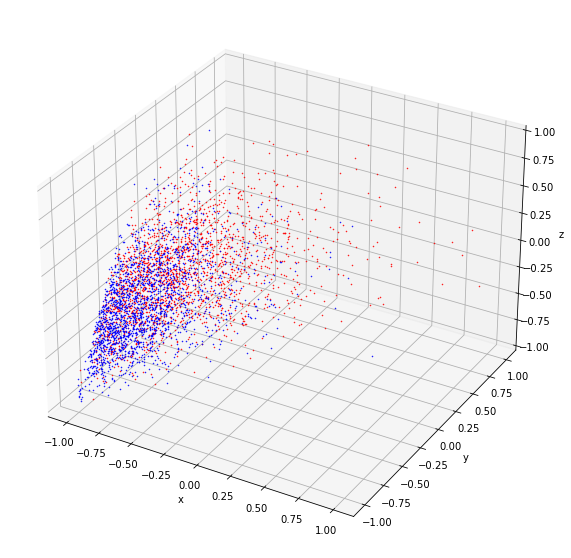

In [19]:
#data capture
# data2 = pickle.load(open("Wjets_part1.pkl","rb"))
# data1 = pickle.load(open("VBS_part1.pkl","rb"))
# Ind = data1.columns


X1 = np.array(data1[Ind[ii]])
X2 = np.array(data2[Ind[ii]])

X = []
for i in range(start + number_training, start + number_training + number_testing):
    X.append(X1[i])
    X.append(X2[i])

#X are normalizated over [-1,1]
if Xmax-Xmin!= 0:
    X = (np.array(X)- Xmin)*2/(Xmax-Xmin)
X = np.array(X) -1
#X = Sqrt(X)
X = np.clip(X,-1,1)

############################################################

Y1 = np.array(data1[Ind[jj]])
Y2 = np.array(data2[Ind[jj]])


Y = []
for i in range(start + number_training, start + number_training + number_testing):
    Y.append(Y1[i])
    Y.append(Y2[i])

#Y are normalizated over [-1,1]
if Ymax-Ymin!= 0:
    Y = (np.array(Y)- Ymin)*2/(Ymax-Ymin)
Y = np.array(Y)-1
Y = Sqrt(Y)
Y = np.clip(Y,-1,1)

############################################################

Z1 = np.array(data1[Ind[kk]])
Z2 = np.array(data2[Ind[kk]])

Z = []
for i in range(start + number_training, start + number_training + number_testing):
    Z.append(Z1[i])
    Z.append(Z2[i])

#Z are normalizated over [-1,1]
if Zmax-Zmin!= 0:
    Z = (np.array(Z)- Zmin)*2/(Zmax-Zmin)
Z = np.array(Z)-1
#Z = Cheb(Z)
Z = Sqrt(Z)
Z = np.clip(Z,-1,1)

############################################################

A1 = np.array(data1[Ind[ll]])
A2 = np.array(data2[Ind[ll]])

A = []
for i in range(start + number_training, start + number_training + number_testing):
    A.append(A1[i])
    A.append(A2[i])

#Z are normalizated over [-1,1]
if Amax-Amin!= 0:
    A = (np.array(A)- Amin)*2/(Amax-Amin)
A = np.array(A)  -1
#A = Sqrt(A)
A = np.clip(A,-1,1)

############################################################

B1 = np.array(data1[Ind[mm]])
B2 = np.array(data2[Ind[mm]])

B = []
for i in range(start + number_training, start + number_training + number_testing):
    B.append(B1[i])
    B.append(B2[i])

#Z are normalizated over [-1,1]
if Bmax-Bmin!= 0:
    B = (np.array(B)- Bmin)*2/(Bmax-Bmin)
B = np.array(B)  -1
#B = Sqrt(B)
B = np.clip(B,-1,1)

############################################################ 

X1 = []
X2 = []
Y1 = []
Y2 = []
Z1 = []
Z2 = []
A1 = []
A2 = []
B1 = []
B2 = []

for i in range(0,len(X)):
    if i % 2 == 0:
        X1.append(X[i])
        Y1.append(Y[i])
        Z1.append(Z[i])
        A1.append(A[i])
        B1.append(B[i])
    else:
        X2.append(X[i])
        Y2.append(Y[i])
        Z2.append(Z[i])
        A2.append(A[i])
        B2.append(B[i])

#TESTING SET VISUALIZATION
if plot_data == 1:
    %matplotlib inline
    fig = plt.figure(figsize = (10,10)) 
    ax = plt.axes(projection='3d')
    ax.plot3D(X1,Y1,Z1,'ro',markersize = 0.5)
    ax.plot3D(X2,Y2,Z2,'bo',markersize = 0.5)
    ax.set_xlabel('x')   
    ax.set_ylabel('y')   
    ax.set_zlabel('z')  

## Preparing for testing
division of the initial vector in smaller vectors in order to fit "max_circuits_supported"

In [20]:
N = int(len(X)/max_circuits_supported)

v = np.zeros((N, max_circuits_supported))
for i in range(0,N):
    for j in range(0,max_circuits_supported):
        v[i][j] = X[j+i*max_circuits_supported]
        
remainder = len(X)%max_circuits_supported     
v_last = np.zeros(remainder)
for j in range(0,remainder):
    v_last[j] = X[j+N*max_circuits_supported]

testing set mapping function

In [21]:
Phi_f = np.zeros((len(X), 2*number_var))
for i in range(0,len(X)):
    for j in range(0, 2*number_var):
        Phi_f[i][j] = Phi_function(X[i],Y[i],Z[i],A[i],B[i])[j]

traing set labels

In [22]:
f_l = []
for i in range(0,len(X)):
    f_l.append(f_label(i))

## Testing & AUC

#### ROC production

Job Status: job has successfully run


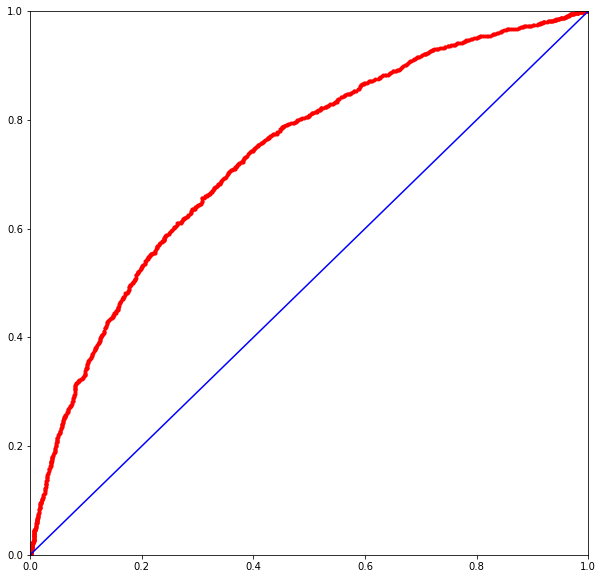

In [23]:
%matplotlib inline  
if plot_AUC_image == 1:
    fig2 = plt.figure(figsize = (10,10)) 
    plt.ylim((0,1))
    plt.xlim((0,1))

counts = training_set(theta_best,circuit,theta,Phi_f)

index_sorted = []
classification = []
for i in range(0,len(X)):
    classification.append(((c_e_ii+c_e_jj)*f_measuration(counts[i])[0]+(c_e_kk+c_e_ll)*f_measuration(counts[i])[2])/(c_e_ii+c_e_jj+c_e_kk+c_e_ll)) 

sort_index = np.argsort(classification)

Classification = []
Labelling = []
for i in range(0,len(X)):
    Classification.append(((c_e_ii+c_e_jj)*f_measuration(counts[sort_index[i]])[0]+(c_e_kk+c_e_ll)*f_measuration(counts[sort_index[i]])[2])/(c_e_ii+c_e_jj+c_e_kk+c_e_ll))  
    Labelling.append((sort_index[i]+1)%2)

treshold = np.linspace(0,1,2000)
False_positive_rate = []
True_positive_rate = []

for k in range(0,len(treshold)):
    C = Classification > treshold[k]
    false_negatives = sum((Labelling - C) == np.int_(np.ones(len(X))))
    false_positives = sum(np.array(Labelling - C) ==np.int_(-np.ones(len(X)))) 
    true_positives = sum(Labelling) - false_negatives 
    true_negatives = sum((Labelling) == np.int_(np.zeros(len(X)))) - false_positives

    False_positive_rate.append(false_positives/(false_positives+true_negatives+0.000001))
    True_positive_rate.append(true_positives/(true_positives+false_negatives+0.000001))
    if plot_AUC_image == 1:
        plt.plot(False_positive_rate[k],True_positive_rate[k],'ro',label = "ROC", markersize=3)
        
if plot_AUC_image == 1:    
    plt.plot(treshold,treshold,'b', markersize=3)                  

#### AUC evaluation
(should be improved with Simpson rule)

In [24]:
def sorter(x,y):
    index = np.zeros(len(x))
    for k in range(0,len(x)):
        min = x[k]
        index[k] = k
        for i in range(k,len(x)):
            if x[i] < min:
                index[k] = i
        buffer = x[k] 
        x[k] = x[int(index[k])]
        x[int(index[k])] = buffer
        buffer = y[k] 
        y[k] = y[int(index[k])]
        y[int(index[k])] = buffer
    return x,y
    
False_positive_rate, True_positive_rate = sorter(False_positive_rate, True_positive_rate)

AUC = 0
for k in range(0,len(False_positive_rate)-1):
    AUC += (True_positive_rate[k]+True_positive_rate[k+1])*(False_positive_rate[k+1]-False_positive_rate[k])/2

print(AUC)

0.7320403742679595


#### Resulting visualzation

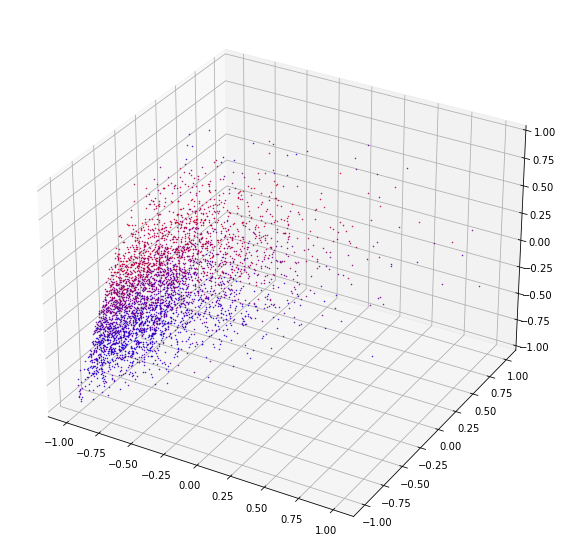

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline  
fig = plt.figure(figsize = (10,10)) 
ax = plt.axes(projection='3d')

classificator = []
f_m = []
for i in range(0,len(X)):
    f_m.append(((c_e_ii+c_e_jj)*f_measuration(counts[i])[0]+(c_e_kk+c_e_ll)*f_measuration(counts[i])[2])/(c_e_ii+c_e_jj+c_e_kk+c_e_ll))

Min = min(f_m)
Max = max(f_m)
delta = Max - Min
    
for i in range(0,len(X)):
    x = [X[i]]
    y = [Y[i]]
    z = [Z[i]]
    ax.plot3D(x,y,z,'o',color = [np.clip((((c_e_ii+c_e_jj)*f_measuration(counts[i])[0]+(c_e_kk+c_e_ll)*f_measuration(counts[sort_index[i]])[2])/(c_e_ii+c_e_jj+c_e_kk+c_e_ll)-Min)/delta,0,1), 0, np.clip(1-(((c_e_ii+c_e_jj)*f_measuration(counts[i])[0]+(c_e_kk+c_e_ll)*f_measuration(counts[sort_index[i]])[2])/(c_e_ii+c_e_jj+c_e_kk+c_e_ll)-Min)/delta,0,1)] ,markersize = 0.5)

if sound == 1:
    import winsound
    frequency = 1000  # Set Frequency To 2500 Hertz
    duration = 1000 # Set Duration To 1000 ms == 1 second
    winsound.Beep(frequency, duration)

## Saving results on file

In [26]:
if save_results == 1:     
    file1 = open("real_device_record.txt","a")
    FP = str(False_positive_rate).strip('[]')
    TP = str(True_positive_rate).strip('[]')
    FM = str(f_m).strip('[]')

    file1.write("BEGIN ATTEMPT \n\n")
    file1.write("number_training = %d \n\n" %number_training)
    file1.write("number_testing = %d \n\n" %number_testing)
    file1.write("SPSA_steps = %d \n\n" %SPSA_steps)
    file1.write("number_var = %d \n\n" %number_var)
    file1.write("variables: %d " %ii + "% d " %jj + "%d \n\n" %kk)
    file1.write("AUC = %d \n\n" %AUC)

    file1.write("False Positives: \n\n"+FP+ "\n\n"+"True Positives: \n\n"+TP+ "\n\n"+"f_measuration: \n\n"+FM + "\n\n\n\n\n")
    file1.close() 